In [3]:
#size=540*108
import kwant
import numpy as np
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))   
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))  
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
las=1
width=30


def make_syst(m,width=50,length=100):
    
    onsite =  m/2*gamma_1 - (4*B)/las**2 * gamma_2
    hopping_x = B/(las**2)*gamma_2 + 1j*g/(2*las)*gamma_3
    hopping_y = B/(las**2)*gamma_2 - 1j*g/(2*las)*gamma_4

    def model():
        structure=kwant.lattice.square(las)
        model_sym= kwant.TranslationalSymmetry(structure.vec((1,0)),structure.vec((0,-1)))
        model_1= kwant.Builder(model_sym)

        model_1[structure(0, 0)] = onsite
        model_1[kwant.builder.HoppingKind((1,0), structure)]  = hopping_x
        model_1[kwant.builder.HoppingKind((0,1), structure)]  = hopping_y

        return model_1

    ########### create the scattering center

    def shape_center(site):
        x, y = site.pos
        return 0 < x <= length and 0 < y <= width

    syst= kwant.Builder()
    syst.fill(model(), shape_center,(1,1))

    ########### create the leads

    width_lead = length//5 

    lead0= kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    lead1= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead2= kwant.Builder(kwant.TranslationalSymmetry((0,1)))

    def shape_lead0(site):
        x, y = site.pos
        return 0 < y <= width

    def shape_lead1(site):
        x, y = site.pos
        return width_lead < x <= 2*width_lead

    def shape_lead2(site):
        x, y = site.pos
        return 3*width_lead < x <= 4*width_lead

    lead0.fill(model(), shape_lead0, (0, 1))
    lead1.fill(model(), shape_lead1, (width_lead+1, 0))
    lead2.fill(model(), shape_lead2, (3*width_lead+1, 0))

    ########### create the six-terminal device
    for lead in [lead0,lead1,lead2, lead0.reversed(),lead2.reversed(),lead1.reversed()]:
        syst.attach_lead(lead)

    return syst.finalized()  

d:\MiniforgeConda\envs\xxy\lib\site-packages\kwant\lattice.py:746: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a, 0), (0, a)), name=name, norbs=norbs)
d:\MiniforgeConda\envs\xxy\lib\site-packages\kwant\lattice.py:746: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a, 0), (0, a)), name=name, norbs=norbs)
d:\MiniforgeConda\envs\xxy\lib\site-packages\kwant\lattice.py:746: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a, 0), (0, a)), name=name, norbs=norbs)
d:\MiniforgeConda\envs\xxy\lib\site-packages\kwant\lattice.py:746: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a, 0), (0, a)), name=name, norbs=norbs)
d:\MiniforgeConda\envs\xxy\lib\site-packages\kwa

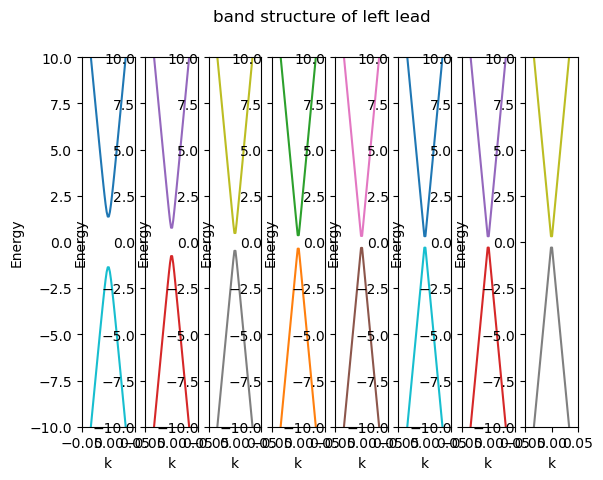

In [7]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(1,8)
fig.suptitle('band structure of left lead')

for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ax.set_xlabel('k')
    ax.set_ylabel('Energy')
    ax.set_ylim(-10,10)
    ax.set_xlim(-0.05,0.05)

syst1=make_syst(30,60,300).leads[0] #提取系统的第一个引线
syst2=make_syst(30,72,360).leads[0]
syst3=make_syst(30,84,420).leads[0]
syst4=make_syst(30,96,480).leads[0]
syst5=make_syst(30,108,540).leads[0]
syst6=make_syst(30,120,600).leads[0]
syst7=make_syst(30,132,660).leads[0]
syst8=make_syst(30,144,720).leads[0]

kwant.plotter.bands(syst1,momenta=np.linspace(-0.05, 0.05, 50), ax=ax1);
kwant.plotter.bands(syst2,momenta=np.linspace(-0.05, 0.05, 50), ax=ax2);
kwant.plotter.bands(syst3,momenta=np.linspace(-0.05, 0.05, 50), ax=ax3);
kwant.plotter.bands(syst4,momenta=np.linspace(-0.05, 0.05, 50), ax=ax4);
kwant.plotter.bands(syst5,momenta=np.linspace(-0.05, 0.05, 50), ax=ax5);
kwant.plotter.bands(syst6,momenta=np.linspace(-0.05, 0.05, 50), ax=ax6);
kwant.plotter.bands(syst7,momenta=np.linspace(-0.05, 0.05, 50), ax=ax7);
kwant.plotter.bands(syst8,momenta=np.linspace(-0.05, 0.05, 50), ax=ax8);


In [6]:
def find_voltages(tmatrix,current):  #注意：该函数返回的V是所有V的矩阵        #tmatrix是传输矩阵，在此处还未定义，current是电流分布[1, 0, 0, -1, 0, 0] 表示电流从端口1流入，端口4流出。
    try:                                                            #np.linalg.solve()函数用于求解线性方程组，返回值是一个数组，数组中的每个元素是一个未知数的解   
        voltage = np.linalg.solve(tmatrix[1:, 1:], current[1:])     #tmatrix[1:, 1:]表示tmatrix的第一行和第一列被删去 current[1:]表示current的第一个元素被删去  
    except np.linalg.LinAlgError as err:                            #当检测到奇异矩阵时，即该函数无解，避免程序崩溃，强制返回零电压
        if 'Singular matrix' in str(err):
            print("Hi there, singular matrix here")
            voltage = [0,0,0,0,0]
        else:
            raise
    return [0, *voltage]    ##在电压列表前添加一个 0，表示第一个端口的电压为0（参考接地）。
  
def resistance_xx(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
  
    def resistance(a, b): 
        return voltage[a-1]-voltage[b-1] ##默认电流为1 ###将端口的序号索引转化为数组索引
  
    return resistance(2, 3) ##电流从端口2流入，端口3流出，电压差为V2-V3
  
def resistance_xy(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
  
    def resistance(a, b):
        return voltage[a-1]-voltage[b-1]
  
    return resistance(2, 6)  



d:\MiniforgeConda\envs\xxy\lib\site-packages\kwant\lattice.py:746: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a, 0), (0, a)), name=name, norbs=norbs)
d:\MiniforgeConda\envs\xxy\lib\site-packages\kwant\lattice.py:746: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a, 0), (0, a)), name=name, norbs=norbs)
d:\MiniforgeConda\envs\xxy\lib\site-packages\kwant\lattice.py:746: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a, 0), (0, a)), name=name, norbs=norbs)
d:\MiniforgeConda\envs\xxy\lib\site-packages\kwant\lattice.py:746: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a, 0), (0, a)), name=name, norbs=norbs)
d:\MiniforgeConda\envs\xxy\lib\site-packages\kwa

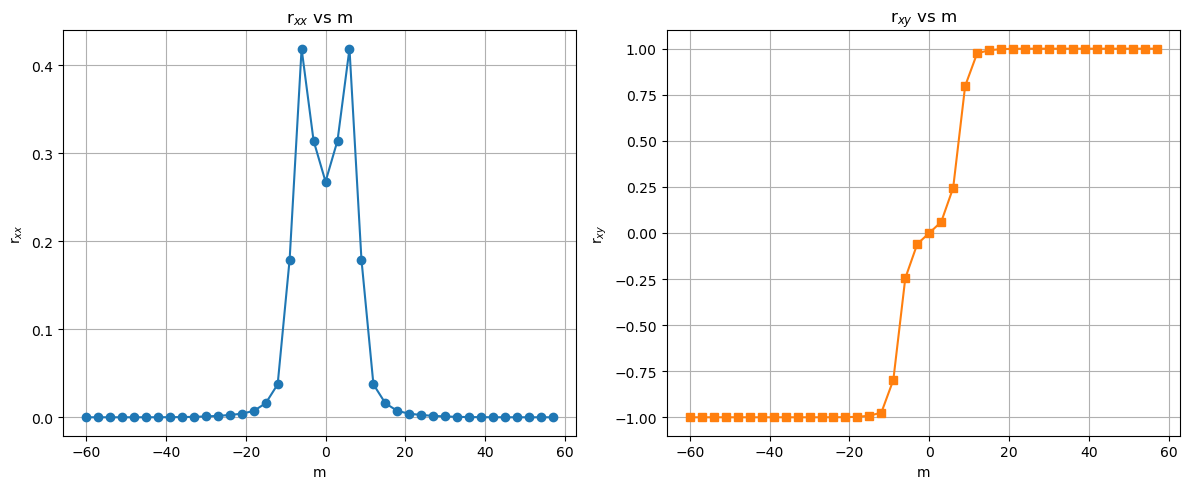

In [8]:
# 计算不同m值下的电阻
m_values = np.arange(-60, 60,3)  
rxx_list = []
rxy_list = []

for m in m_values:
    syst = make_syst(m, width=84, length=420)
    smat = kwant.smatrix(syst, energy=9.0)
    tmat = smat.conductance_matrix()
    rxx_list.append(resistance_xx(tmat))
    rxy_list.append(resistance_xy(tmat))

#画图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(m_values, rxx_list, 'o-', color='C0')
ax1.set_xlabel('m')
ax1.set_ylabel('r$_{xx}$')
ax1.set_title('r$_{xx}$ vs m')
ax1.grid(True)

ax2.plot(m_values, rxy_list, 's-', color='C1')
ax2.set_xlabel('m')
ax2.set_ylabel('r$_{xy}$')
ax2.set_title('r$_{xy}$ vs m')
ax2.grid(True)

plt.tight_layout()
plt.show()